In [35]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import alpaca_trade_api as tradeapi
from newsapi import NewsApiClient

from datetime import datetime, timedelta
import numpy as np

from numpy.random import seed
seed(1)
import requests
from tensorflow import random
random.set_seed(2)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


import hvplot.pandas

%matplotlib inline

In [36]:
load_dotenv()

True

In [37]:
alpaca_api_key = os.getenv("alpaca_api_key")
alpaca_secret_key = os.getenv("alpaca_secret_key")

In [38]:
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


In [39]:
api_key = os.getenv("news_api")
newsapi = NewsApiClient(api_key=api_key)


In [40]:
# To establish continuity, using a 15 minute interval, with same timestamps,
# like Samuel's code
timeframe = "1D"
start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()


In [41]:
# Applying SPY - S&P 500 index to the auto stocks I am researching
ticker = ["SPY", "TSLA", "F", "GM"]
stock_ticker = alpaca_api.get_barset(
    ticker, 
    timeframe,  
    start=start_date, 
    end=end_date, 
    limit=1000  
    ).df


In [42]:
# Drop any nan's
stock_ticker.dropna(inplace=True)
stock_ticker.head()

F                                    GM  \
                           open   high   low   close    volume   open   
2019-01-02 00:00:00-05:00  7.53  8.020  7.48  7.8950  40792880  32.85   
2019-01-03 00:00:00-05:00  7.97  7.990  7.78  7.8000  34718602  33.34   
2019-01-04 00:00:00-05:00  7.91  8.120  7.85  8.0750  36423894  32.80   
2019-01-07 00:00:00-05:00  8.11  8.365  7.85  8.2999  32987511  33.71   
2019-01-08 00:00:00-05:00  8.42  8.540  7.90  8.3750  40123824  35.00   

                                                               SPY          \
                              high    low   close   volume    open    high   
2019-01-02 00:00:00-05:00  33.8050  32.41  33.585  6498614  245.98  251.21   
2019-01-03 00:00:00-05:00  33.6800  32.22  32.290  9543046  248.23  248.57   
2019-01-04 00:00:00-05:00  33.5711  32.43  33.365  8804555  247.59  253.11   
2019-01-07 00:00:00-05:00  34.9650  33.48  34.420  8256201  252.69  255.95   
2019-01-08 00:00:00-05:00  35.6800  34.49  34.850  8938684  256.82  257.31   

                                                        TSLA          \
                              low   close     volume    open    high   
2019-01-02 00:00:00-05:00  245.95  249.89  107236613  306.50  315.13   
2019-01-03 00:00:00-05:00  244.03  244.46  113782919  307.00  309.40   
2019-01-04 00:00:00-05:00  247.17  252.41  122528832  306.00  318.00   
2019-01-07 00:00:00-05:00  251.69  254.40   88317608  321.66  336.74   
2019-01-08 00:00:00-05:00  254.00  256.65   88864452  341.98  344.01   

                                                         
                                low     close    volume  
2019-01-02 00:00:00-05:00  298.8000  309.8699  10751296  
2019-01-03 00:00:00-05:00  297.3800  300.3100   6672221  
2019-01-04 00:00:00-05:00  302.7300  317.5400   6983846  
2019-01-07 00:00:00-05:00  317.7508  334.9860   7193888  
2019-01-08 00:00:00-05:00  327.0200  335.4900   6567180

In [43]:
# Create dataframe for auto stocks and S&P 500
auto_df = pd.DataFrame()
auto_df["S&P 500"] = stock_ticker["SPY"]["close"]
auto_df["Tesla"] = stock_ticker["TSLA"]["close"]
auto_df["Ford"] = stock_ticker["F"]["close"]
auto_df["GM"] = stock_ticker["GM"]["close"]


In [44]:
auto_df.index = auto_df.index.date 
auto_df.dropna(inplace=True)
auto_df.head()

,S&P 500,Tesla,Ford,GM
2019-01-02,249.89,309.8699,7.8950,33.585
2019-01-03,244.46,300.3100,7.8000,32.290
2019-01-04,252.41,317.5400,8.0750,33.365
2019-01-07,254.40,334.9860,8.2999,34.420
2019-01-08,256.65,335.4900,8.3750,34.850


In [45]:
# Calculating the percentage change from the current date to the previous date.
# Dropping null values
auto_returns = auto_df.pct_change().dropna()
auto_returns.head()

,S&P 500,Tesla,Ford,GM
2019-01-03,-0.021730,-0.030851,-0.012033,-0.038559
2019-01-04,0.032521,0.057374,0.035256,0.033292
2019-01-07,0.007884,0.054941,0.027851,0.031620
2019-01-08,0.008844,0.001505,0.009048,0.012493
2019-01-09,0.004130,0.009032,0.041194,0.009613


In [46]:
csv_path = Path("../raw_data/oil_returns.csv/")
oil_data = pd.read_csv(csv_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
oil_data.sort_index(ascending = True, inplace = True)
oil_data.head()

,WTI_oil_ppb
Date,
2016-06-28,47.93
2016-06-29,49.85
2016-06-30,48.27
2016-07-01,49.02
2016-07-05,46.73


In [47]:
# Creating database of five years of prices of a barrel of oil, downloaded 
# from Quandl
oil_output = pd.DataFrame()
oil_output["Oil_PPB"] = oil_data["WTI_oil_ppb"]
oil_output.head()

,Oil_PPB
Date,
2016-06-28,47.93
2016-06-29,49.85
2016-06-30,48.27
2016-07-01,49.02
2016-07-05,46.73


In [48]:
csv_covid = Path("../raw_data/covid_data.csv/")
covid_data = pd.read_csv(csv_covid, index_col="Date", parse_dates=True, infer_datetime_format=True)
covid_data.tail()

,New Cases,7-Day Moving Avg,Historic Cases
Date,,,
2020-01-26,3,6,0
2020-01-25,3,5,0
2020-01-24,1,5,0
2020-01-23,2,5,0
2020-01-22,33,4,0


In [49]:
covid_df = pd.DataFrame()
covid_df["US_Covid_Cases"] = covid_data["New Cases"]
covid_df.head()

,US_Covid_Cases
Date,
2021-07-02,15555
2021-07-01,17911
2021-06-30,14353
2021-06-29,14823
2021-06-28,8669


In [50]:
combined_df = auto_df.join(oil_output, how="inner")
combined_df.head()

,S&P 500,Tesla,Ford,GM,Oil_PPB
2019-01-02,249.89,309.8699,7.8950,33.585,46.31
2019-01-03,244.46,300.3100,7.8000,32.290,46.92
2019-01-04,252.41,317.5400,8.0750,33.365,47.76
2019-01-07,254.40,334.9860,8.2999,34.420,48.27
2019-01-08,256.65,335.4900,8.3750,34.850,49.58


In [51]:
data = covid_df.join(combined_df, how="inner")
data.sort_index(inplace=True)
data.tail()

,US_Covid_Cases,S&P 500,Tesla,Ford,GM,Oil_PPB
2021-06-22,13361,423.06,623.69,14.91,59.24,73.15
2021-06-23,14188,422.60,656.57,15.42,60.12,73.11
2021-06-24,15208,425.09,679.72,15.27,60.05,73.31
2021-06-25,13265,426.57,671.60,15.20,60.28,74.21
2021-06-28,8669,427.48,688.47,14.96,58.64,72.98


In [52]:
# Applying Exponentially Weighted Moving Average to weight appropriately 
# distant past data versus near future data for our control stock, TSLA.
tsla_ewma = pd.DataFrame()
tsla_ewma["Tesla"] = data["Tesla"]
tsla_ewma["SMA10"] = data.Tesla.rolling(window=10).mean()
tsla_ewma["EWMA10"] = data["Tesla"].ewm(halflife=5).mean()
tsla_ewma.tail() 

,Tesla,SMA10,EWMA10
2021-06-22,623.69,612.491,613.043206
2021-06-23,656.57,618.270,618.677725
2021-06-24,679.72,625.230,626.579613
2021-06-25,671.60,631.401,632.407477
2021-06-28,688.47,638.479,639.664739


In [53]:
data = tsla_ewma.join(covid_df, how="inner")
data.dropna(inplace=True)

In [54]:
train = data['2020':'2020']
test = data['2021']

In [55]:
# Convert the test and train SMA10 to a dataframe
X_train = train["SMA10"].to_frame()
y_train = train["Tesla"]
X_test = test["SMA10"].to_frame()
y_test = test["Tesla"]

In [56]:
# Fitting a sklearn linear regression using X_train, y_train
tesla_model = LinearRegression()
tesla_model.fit(X_train, y_train)

LinearRegression()

In [57]:
tesla_prediction = tesla_model.predict(X_test)

In [58]:
tesla_results = y_test.to_frame()
tesla_results["Predicted Return"] = tesla_prediction

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C6BBDFCA0>,
      dtype=object)

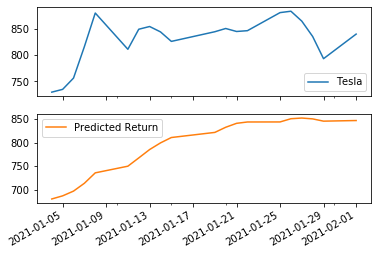

In [59]:
tesla_results[:20].plot(subplots=True)


# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the DataFrame above)
mse = mean_squared_error(
    tesla_results["Tesla"],
    tesla_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

In [60]:
# Construct a DataFrame using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that DataFrame:  
in_sample_results["In-sample Predictions"] = tesla_model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Tesla"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 206.84180690216155


In [61]:
tsla_signals_df = data.loc[:, ['Tesla']].copy()

# Set the short window and long windows
short_window = 50
long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
tsla_signals_df['SMA50'] = tsla_signals_df['Tesla'].rolling(window=short_window).mean()
tsla_signals_df['SMA100'] = tsla_signals_df['Tesla'].rolling(window=long_window).mean()
tsla_signals_df['Signal'] = 0.0
tsla_signals_df["Signal"][short_window:] = np.where(
    tsla_signals_df["SMA50"][short_window:] < tsla_signals_df["SMA100"][short_window:], 1.0, 0.0
)
tsla_signals_df['Entry/Exit'] = tsla_signals_df['Signal'].diff()

In [62]:
tsla_signals_df.tail(100)

,Tesla,SMA50,SMA100,Signal,Entry/Exit
2021-02-04,849.99,717.889752,571.733815,0.0,0.0
2021-02-05,852.61,725.153152,576.535814,0.0,0.0
2021-02-08,863.30,731.985752,580.971164,0.0,0.0
2021-02-09,849.25,737.853552,584.969864,0.0,0.0
2021-02-10,805.00,742.473552,588.602264,0.0,0.0
...,...,...,...,...,...
2021-06-22,623.69,643.910702,679.589737,1.0,0.0
2021-06-23,656.57,641.795102,678.222327,1.0,0.0
2021-06-24,679.72,640.733302,676.619361,1.0,0.0
2021-06-25,671.60,639.388302,674.607461,1.0,0.0
